In [1]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import CSVLogger
from torch.utils.data import *
from collections.abc import Iterable
from ..data_utils import *

## Define Dataset

In [2]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=32, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=32, steps=1)

In [3]:
batch_size = 6
device = 'cuda'
folder_to_save_models = 'weights'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [4]:
from vunet_model import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=32)

## Build Learner

In [5]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard, valid_leaderboard2], model_dir=folder_to_save_models, cbs=CSVLogger)

In [6]:
learn.summary()

Net1 (Input shape: 6 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

In [7]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

## Training

In [8]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,110.652817,4.828396,0.003629,0.003629,33:36
1,42.732708,0.109388,0.002523,0.002523,33:34


In [9]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

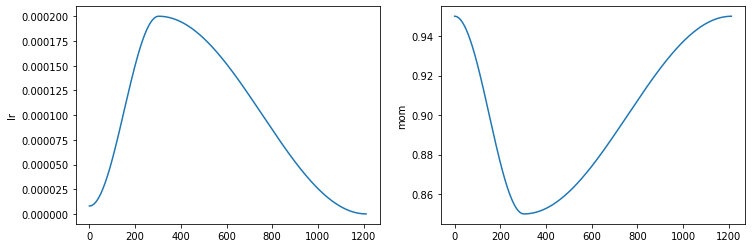

In [10]:
learn.recorder.plot_sched()

In [12]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.251354,0.095048,0.001316,0.001316,32:35
1,0.076558,0.002068,0.001418,0.001418,33:20


In [13]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [14]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.102324,0.061777,0.001814,0.001814,33:50
1,0.034046,0.001675,0.001352,0.001352,33:02


In [15]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [ ]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

In [ ]:
learn.save('Comb_8')

## Testing

In [5]:
learn.load('Comb_8')

NameError: name 'learn' is not defined

In [7]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [22]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
sample = preds[0][0].cpu().detach().numpy()
print(sample.shape)

(32, 256, 256)


In [23]:
label = y[0].cpu().detach().numpy()
print(label.shape)

(32, 256, 256)


In [35]:
sample = recover(sample, 17, 32)
label = recover(label, 17, 32)

In [36]:
print(sample[:,0,0])
print(label[:,0,0])

[22.621347 23.466751 23.101322 24.68644  22.67313  22.80384  22.127378
 23.019608 21.751848 24.25262  22.48509  23.716496 23.29439  22.231812
 22.428467 21.951134 23.01783  21.473145 22.776283 22.992214 22.836554
 23.373703 22.64371  23.743477 23.206545 22.50293  22.397352 23.553791
 21.430391 23.777962 22.68718  24.55044 ]
[22.51   22.6175 22.69   22.6375 22.7575 22.7    22.9175 22.6075 22.8475
 22.66   22.87   22.645  22.76   22.915  22.535  22.645  22.49   22.95
 22.6525 22.7275 22.625  22.5325 22.6    22.6525 22.62   22.4825 22.6025
 22.7225 22.995  22.8675 23.02   23.0725]


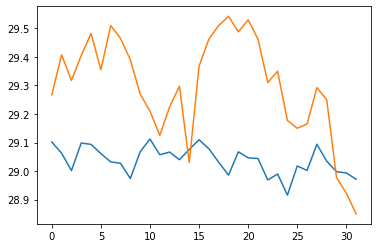

In [50]:
plt.plot(sample[:,100,100])
plt.plot(label[:,100,100])

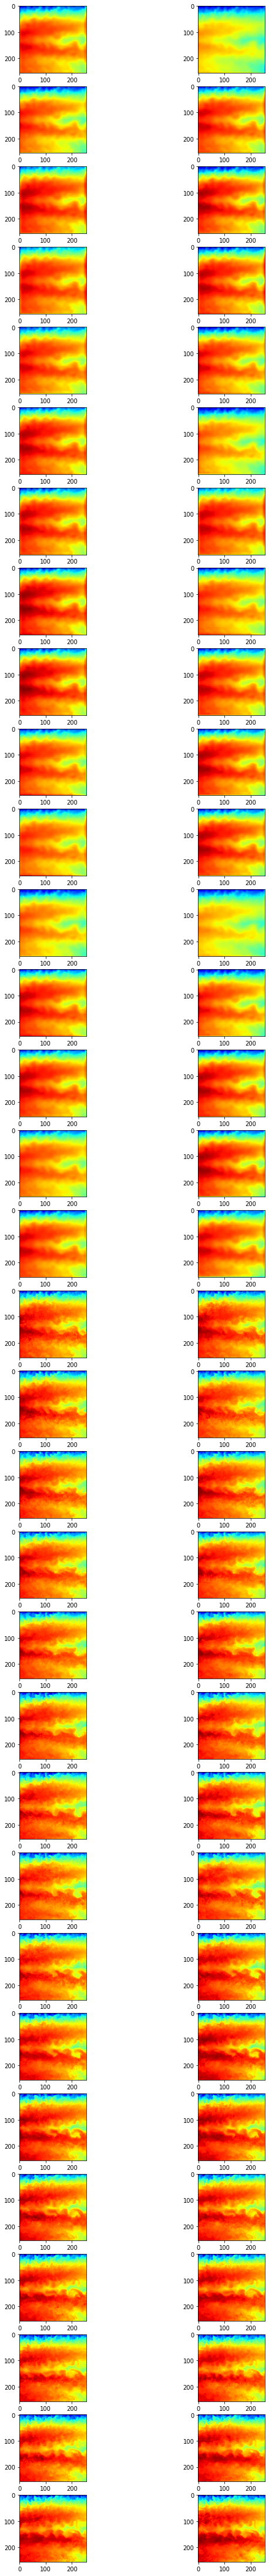

In [38]:
plt.figure(figsize=(10,80))
for i in range(sample.shape[0]):
    plt.subplot(sample.shape[0], 2, i+1)
    plt.imshow(sample[i], cmap='jet')
    plt.subplot(sample.shape[0], 2, i+1+sample.shape[0])
    plt.imshow(label[i], cmap='jet')
